# Initial EDA

## Introduction

### Business objective

The business goal is to deliver a pricing model, that can predict the acceptable per night price for Airbnb apartment based on its properties and the offered amenities.

The model must be available for predictions through the API

### Data

Model must be trained on the most recent [Airbnb dataset for Barcelona](http://insideairbnb.com/get-the-data.html) from the Detailed Listings data, compiled on 11 December, 2022 ([listings.csv.gz](http://data.insideairbnb.com/spain/catalonia/barcelona/2022-12-11/data/listings.csv.gz))

Data description is avalable in [Data Dictionary for listings.csv detailed file](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596).

### Approach

We set the goal of the project to obtain a working model in the shortest possible time for subsequent continuous improvement. Thus the whole team will benefit from discovering the power of machine learning from the very beginning of the project, and the data science team from getting quick feedback across the spectrum of model use. This will reduce the uncertainty inherent in data science projects, leaving only iterations to improve data understanding and model quality.

The proposed approach to the solution includes the following steps: 
- Take the minimum set of features, based on common sense. 
- Perform an initial explanatory analysis of the data to understand the overall structure of the data and identify critical issues that are blocking the model development. 
- Correct these issues, train the model and evaluate its performance on the test dataset. 
- Deliver the trained model to an API-wrapped Docker container with a prediction endpoint. 
- The project is ready for continuous improvement until the quality of the model meets the business goals.


### Inital EDA stages

We start with the following features from [Data Dictionary for listings.csv detailed file](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596):
1. `host_is_superhost`
1. `neighbourhood_group_cleansed`
1. `property_type`
1. `room_type`
1. `accommodates`
1. `bathrooms_text`
1. `bedrooms`
1. `beds`
1. `number_of_reviews`

and a target column `price`. 
    
Based on common sense, we assume that the price depends on the location of the hotel and its characteristics, and also probably depends on the status of the host and the number of reviews.

Based on this, we take the following steps:
1. Specify the selected functions in the `params.yaml` file in the project directory.
1. Run the `make make_data` command to get the data from the data URL (also specified in params.yaml) and split it into train and test datasets. The datasets will be saved in the `data/raw` directory.
1. Load data into notebook.
1. Examine the structure and quality of the data.
1. Find problems and propose solutions to manage them during the data cleansing phase.



### Conclusions

The following conclusions were drawn from the explanatory data analysis:

- There are duplicates in the data set and they need to be removed.
- There are also missing values in the dataset. Since the number of samples with missing values is less than 10%, we simply discard them as an initial approach to handling the cleanup step.
- Data type errors have been identified that should be eliminated during data cleansing: the target `price` and the `host_is_superhost` feature must be converted to a numeric type.
- Numerical features `bedrooms`, `beds` and `accommodates` have a low cardinality. They can be treated as categorical.
- Since the target has a lognormal distribution, we take $log_{10}$ from it to predict. To restore the price from the forecast, we will raise 10 to the power of the predicted value. 
- We exclude samples with price greater than 500 EUR from the training and test dataset.
- To eliminate rare observations and outliers, we limit the feature values as follows:
    - accommodates less than 11;
    - bedrooms less than 6;
    - beds less than 11.
- If the model is to be used to make predictions with feature values outside these limits, the model will return -1 as a prediction.

## Code preparation

In [21]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload

# always reload modules so that as we change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load modules

In [22]:
import pandas as pd
import numpy as np
from os import path
from src.utils.functions import load_params, get_abs_path
from src.data.functions import true_false_to_int, price_to_int, is_features_valid
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [23]:
PARAMS = load_params()

## Load data

In [24]:
data_path = get_abs_path(PARAMS['data']['raw_data_path'], PARAMS["data"]["train_data_file"])
df = pd.read_csv(data_path)

## Structure Investigation

Before looking at the content of our features, let’s first look at the general structure of the dataset.

In [25]:
df.shape

(12622, 10)

We load dataset that has 12622 rows with 10 columns. That is exactly what we are expected as we selected 9 features plus 1 target.

And how many different data types do these 16 features contain?

In [26]:
pd.value_counts(df.dtypes)

object     6
int64      2
float64    2
dtype: int64

6 features are objects and other are numerical.

### Structure of non-numerical features

In [27]:
df.select_dtypes(exclude='number').head()

,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,bathrooms_text,price
0,f,Gràcia,Private room in bed and breakfast,Private room,1.5 shared baths,$28.00
1,f,Horta-Guinardó,Private room in rental unit,Private room,1 shared bath,$30.00
2,f,Ciutat Vella,Entire rental unit,Entire home/apt,1 bath,$143.00
3,f,Ciutat Vella,Private room in rental unit,Private room,1 shared bath,$53.00
4,f,Ciutat Vella,Private room in rental unit,Private room,1.5 baths,$32.00


The target `price` is of type string and includes a currency symbol and delimiters. We have to convert it to a number.

Using the `.describe()` function we can investigate how many unique values each non-numerical feature has and with which frequency the most prominent value is present.

In [28]:
df.select_dtypes(exclude='number').describe()

,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,bathrooms_text,price
count,12621,12622,12622,12622,12614,12622
unique,2,10,59,4,35,517
top,f,Eixample,Entire rental unit,Entire home/apt,1 bath,$50.00
freq,10455,4612,6313,7518,5127,322


`host_is_superhost` is also a string type, but it has only two unique values. Thus it can be represented by the numbers 0 and 1. We also need to convert it.

The rest non-numerical features are categorical ones: 10 neighborhoods, 59 property types, 4 room types and 35 varieant of bedroom texts.

Let's convert the price to a number. Before doing this, we check if each sample contains "0.00" in the price value, which means that all prices are integers.

In [29]:
df.price.str.contains('.00').count() == df.shape[0]

True

Yes the price is an integer.

In [30]:
df.price = df.price.apply(price_to_int)

In [31]:
df.host_is_superhost = df.host_is_superhost.apply(true_false_to_int)

We convert price and host status from string to integer.

### Structure of numerical features

Next, let’s take a closer look at the numerical features.

In [32]:
df.select_dtypes(include='number').describe()

,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,price
count,12621.000000,12622.000000,12153.000000,12405.000000,12622.000000,12622.000000
mean,0.171619,3.457218,1.737596,2.423781,42.296387,137.940897
std,0.377064,2.184182,1.050416,1.893981,80.979482,1043.092107
min,0.000000,1.000000,1.000000,1.000000,0.000000,8.000000
25%,0.000000,2.000000,1.000000,1.000000,1.000000,45.000000
50%,0.000000,3.000000,1.000000,2.000000,8.000000,80.000000
75%,0.000000,4.000000,2.000000,3.000000,44.000000,126.000000
max,1.000000,16.000000,20.000000,30.000000,1476.000000,90000.000000


Minimum values of all features and target are meaningfull. But the maximum price 90 000 is unrealistic and goes far beyond 75th percentile. 30 beds, 20 bedrooms, and 16 accomodations seem pretty big too. 

Now let’s investigate how many unique values each of these feature has. This process will give us some insights about the number of binary (2 unique values), probably ordinal (3 to ~10 unique values) and continuous (more than 10 unique values) features in the dataset.

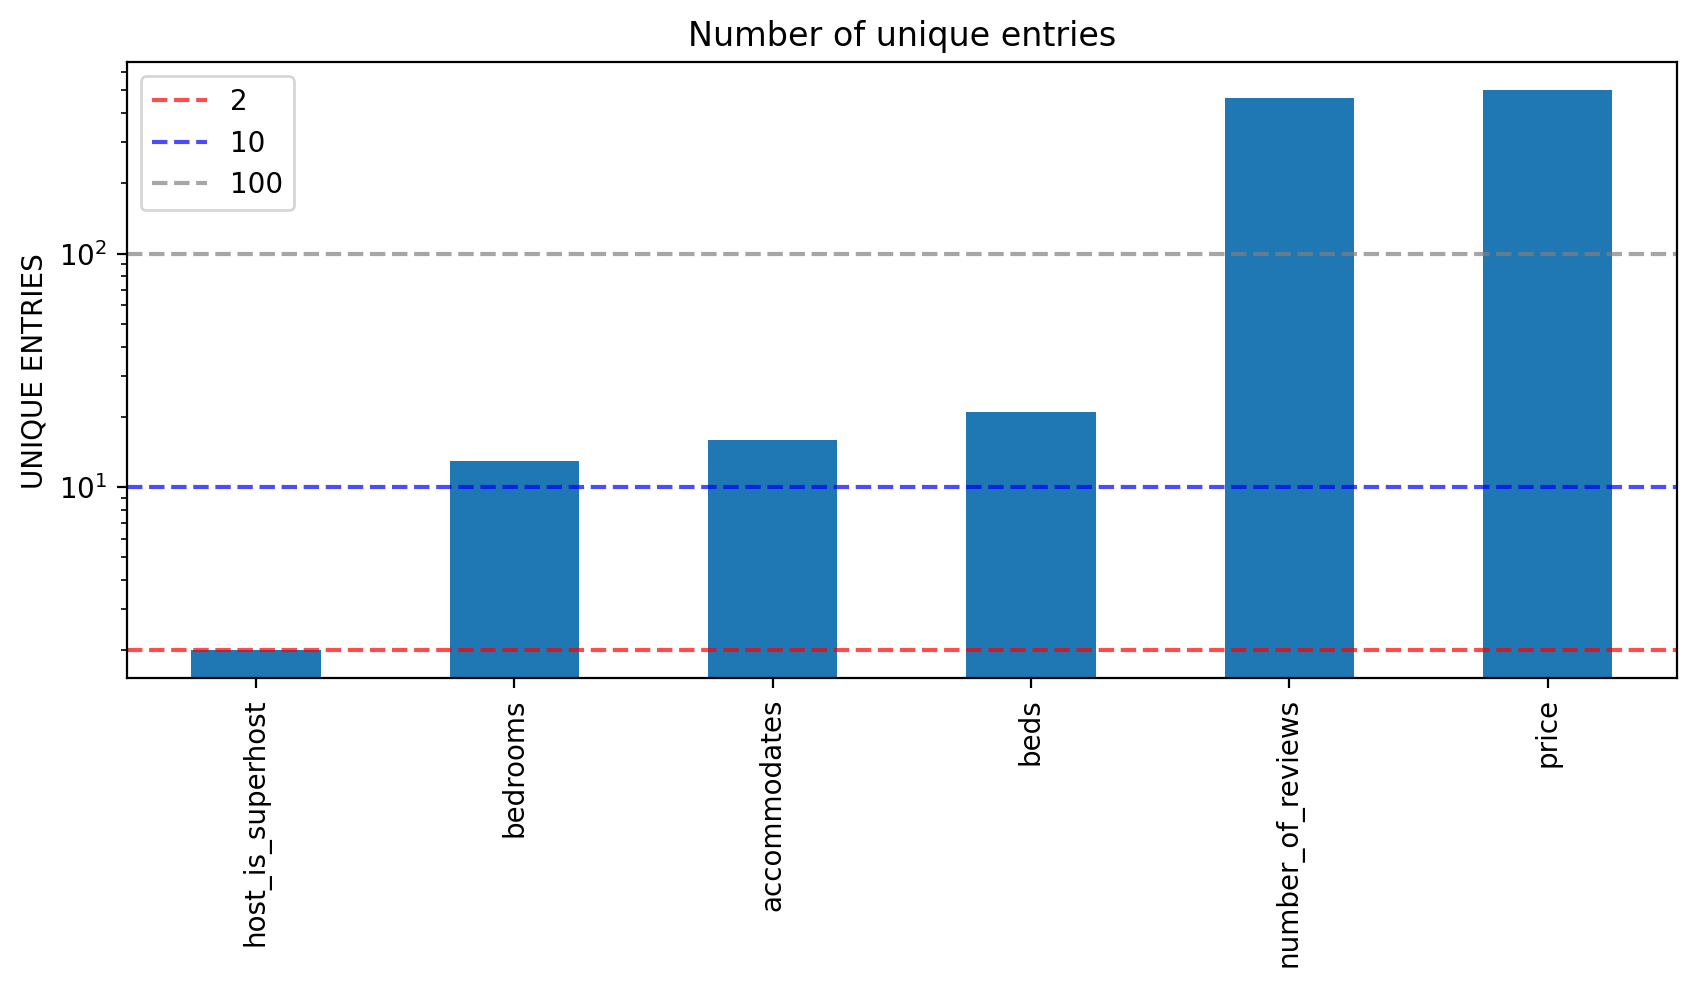

In [33]:
# For each numerical feature compute number of unique entries and sort them
unique_values = df.select_dtypes(include='number').nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(
    logy = True, figsize = (10, 4),
    title = "Number of unique entries"
);

# add horizontal lines for 2, 10 and 100 to easily recognize
# binary, ordinal and continious features
plt.axhline(2, color='red', alpha=0.7, linestyle='dashed')
plt.axhline(10, color='blue', alpha=0.7, linestyle='dashed')
plt.axhline(100, color='gray', alpha=0.7, linestyle='dashed')

plt.ylabel("Unique entries".upper())
plt.legend(['2', '10', '100'])
plt.show()

Only `number_of_reviews` are continious. Number of bedrooms, beds and accomodates has low cardinality. 


### Conclusions

We have studied the structure of categorical and numerical features. 

Data type errors have been identified that should be eliminated during data cleansing: the target feature and the `host_is_superhost` feature must be converted to a numeric type.

Numerical features `bedrooms`, `beds` and `accommodates` have a low cardinality. They can be treated as categorical.

## Quality Investigation

### Duplicates

In [34]:
duplicates_number = df.duplicated().sum()
print(f"{duplicates_number} are found in the dataset")

498 are found in the dataset


### Missing values

In [35]:
df.isna().sum()

host_is_superhost                 1
neighbourhood_group_cleansed      0
property_type                     0
room_type                         0
accommodates                      0
bathrooms_text                    8
bedrooms                        469
beds                            217
number_of_reviews                 0
price                             0
dtype: int64

There are several samples in the dataset with missing values in the  `host_is_super_host`, `bedrooms` and `beds` columns. Since the number of such samples is less than 10% of the data set, we can abandon it at the first stage of the project.

### Conclusions

There are duplicates in the data set and they need to be removed.

There are also missing values in the dataset. Since the number of samples with missing values is less than 10%, we simply discard them as an initial approach to handling the cleanup step.

## Content Investigation

### Numerical features distribution

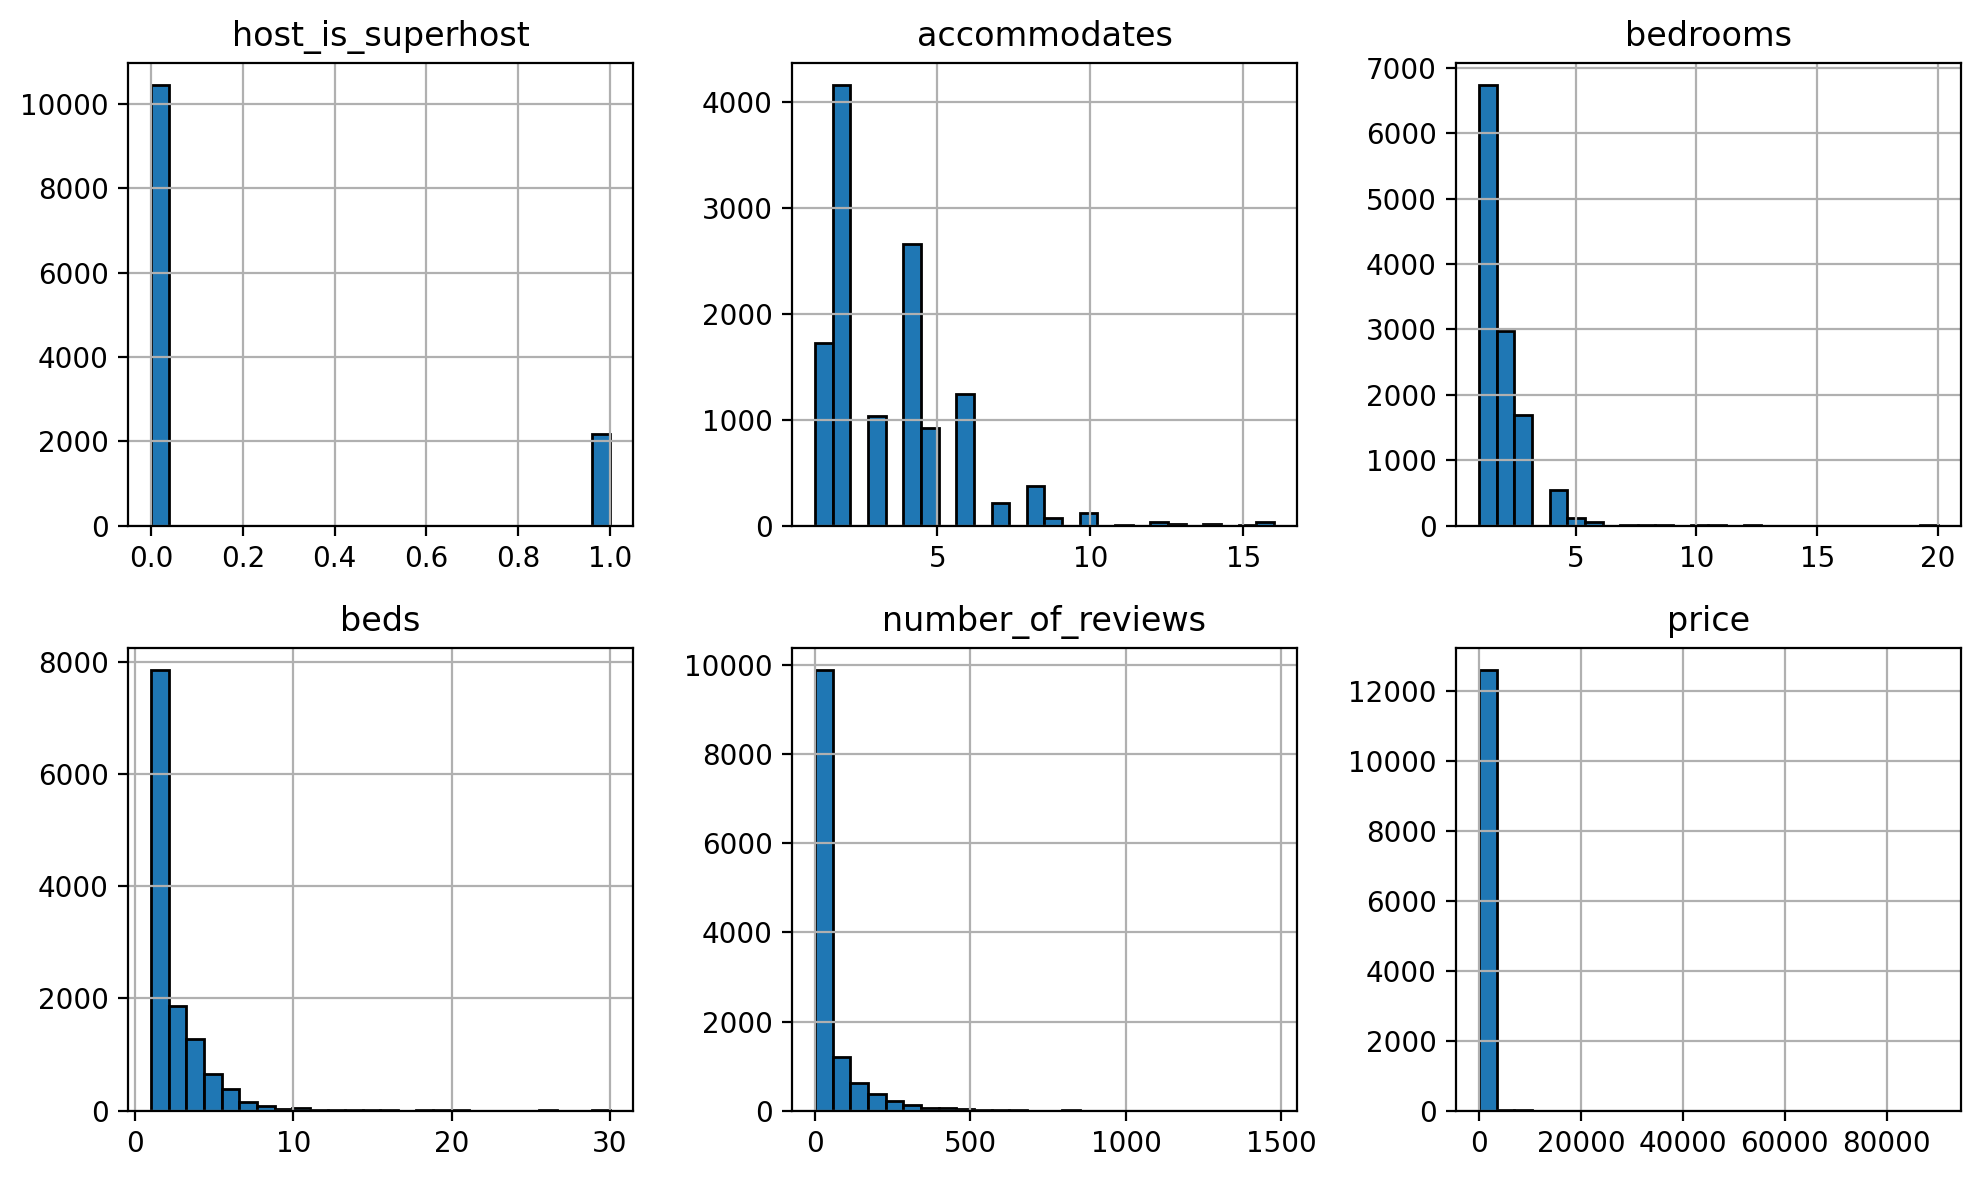

In [36]:
df.hist(bins=26, figsize=(10, 6), layout=(-1, 3), edgecolor="black")
plt.tight_layout()
plt.show()

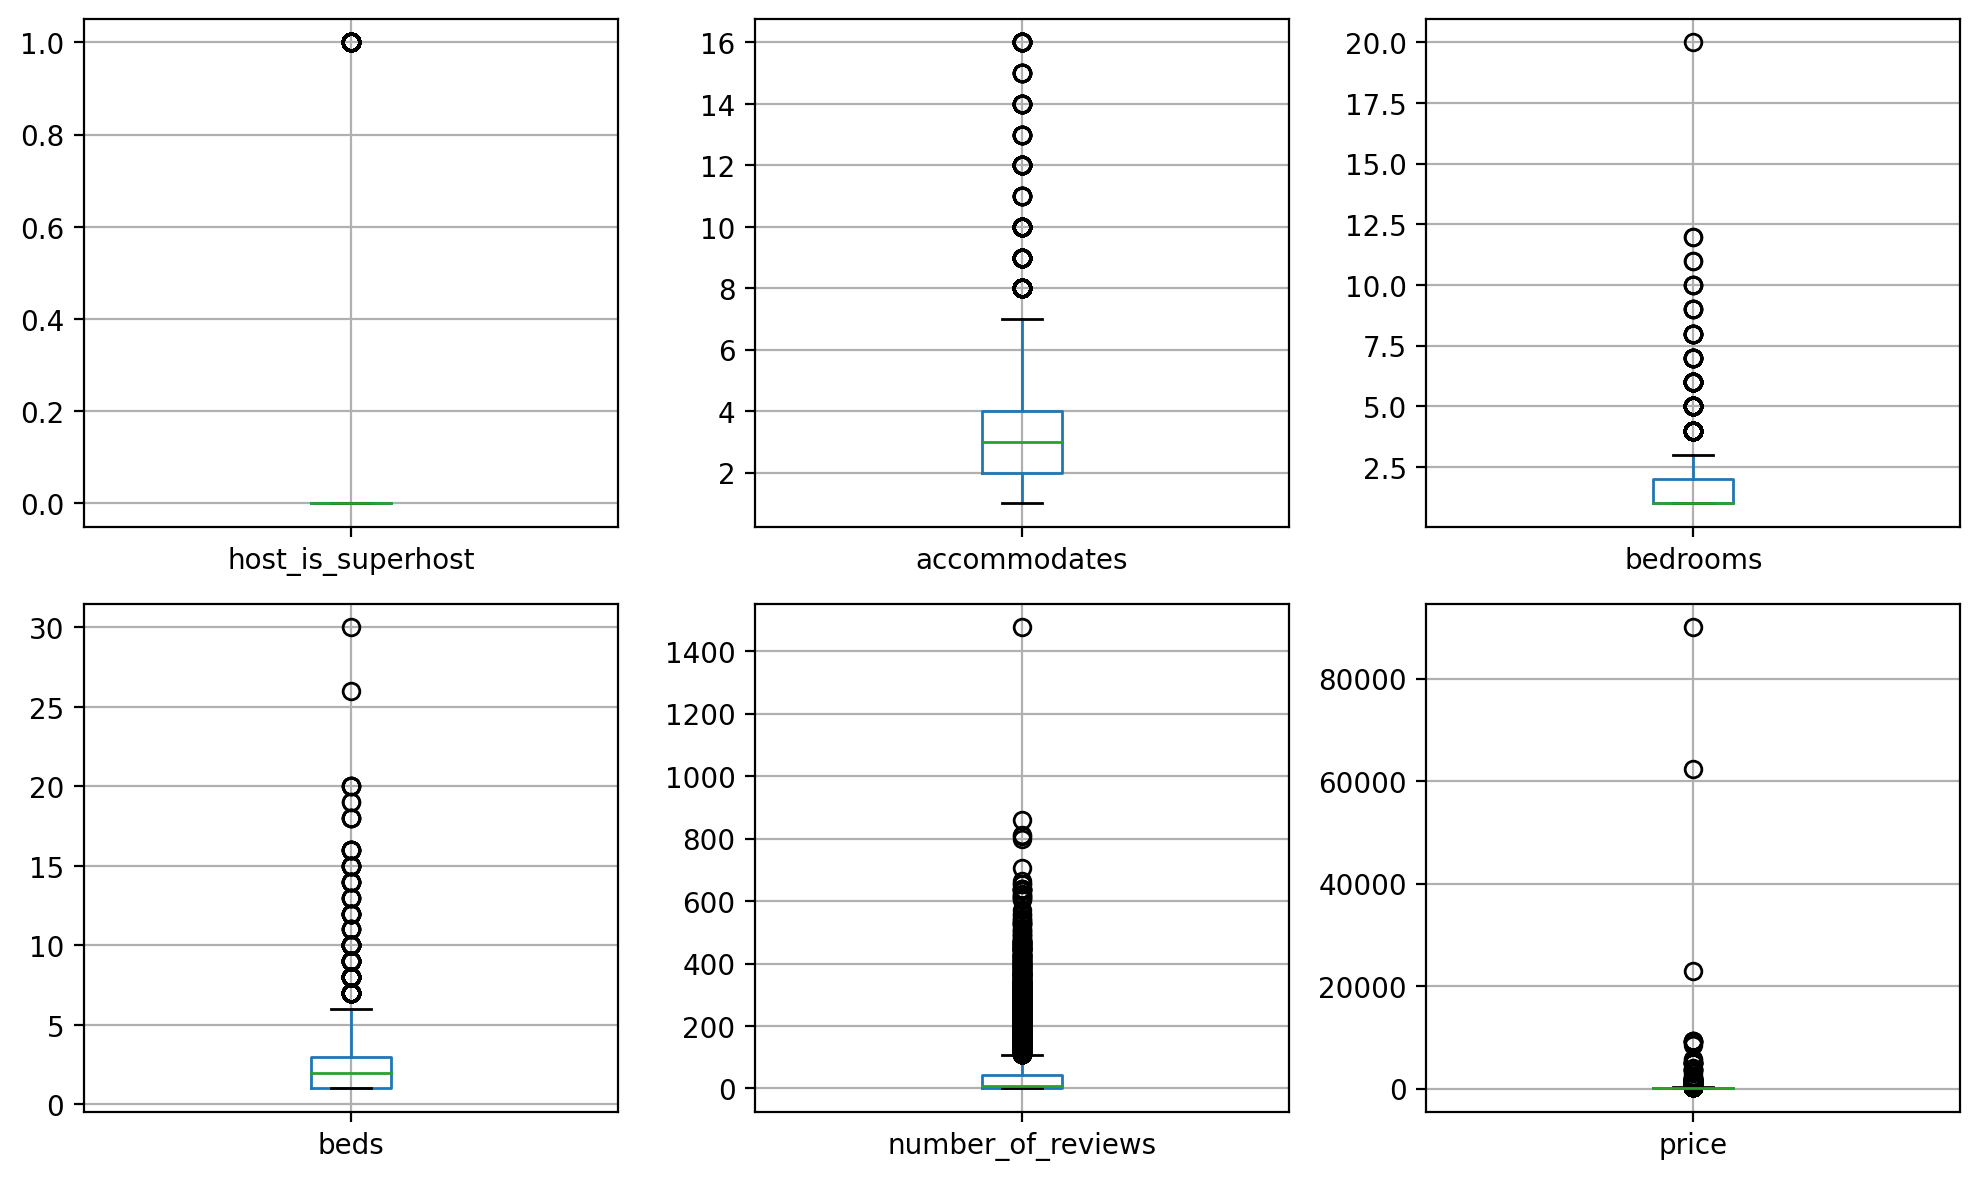

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

for column, ax in zip(df.select_dtypes(include='number'), axes.ravel()):
    df.boxplot(column=column, ax=ax)
    ax.set(ylabel='')
plt.tight_layout()
plt.show()

Accomodates and beds have rare values above 10, bedrooms — above 5. For number of reviews reviews we see a distinct outlier with value greater than 1400.

Let's take a closer look at the target.

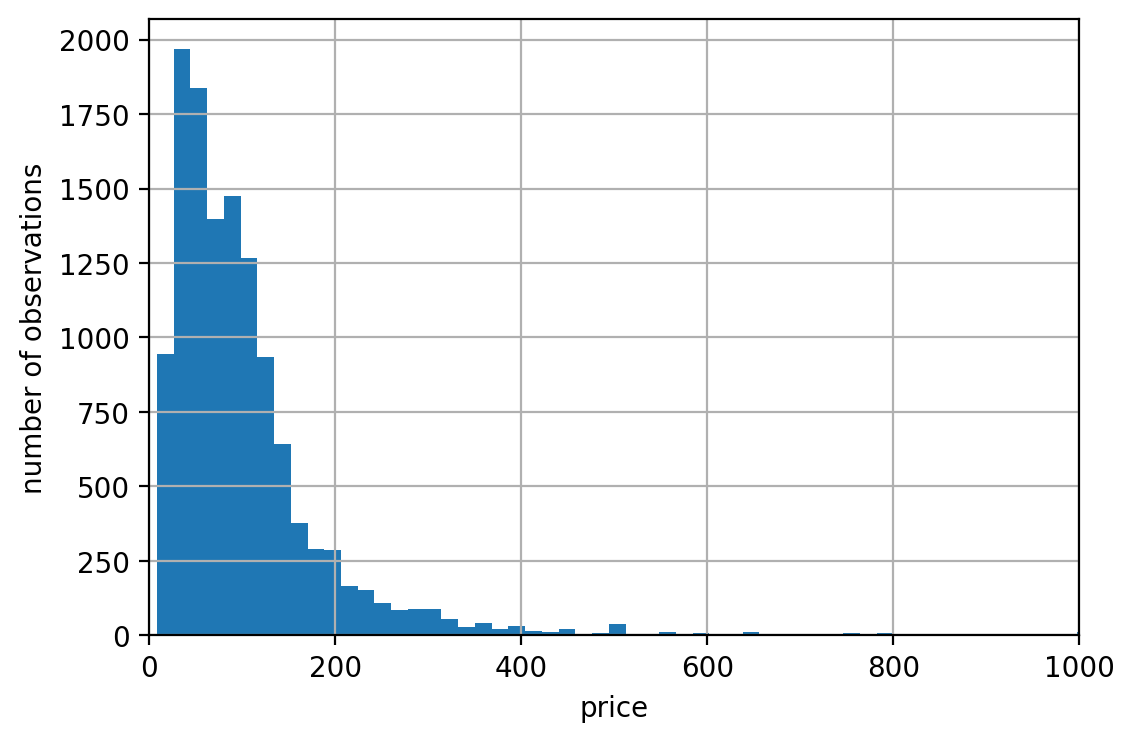

In [38]:
df.price.hist(bins=5000, figsize=(6,4))
plt.xlim(0, 1000)
plt.xlabel('price')
plt.ylabel('number of observations')
plt.show()

(0.0, 1000.0)

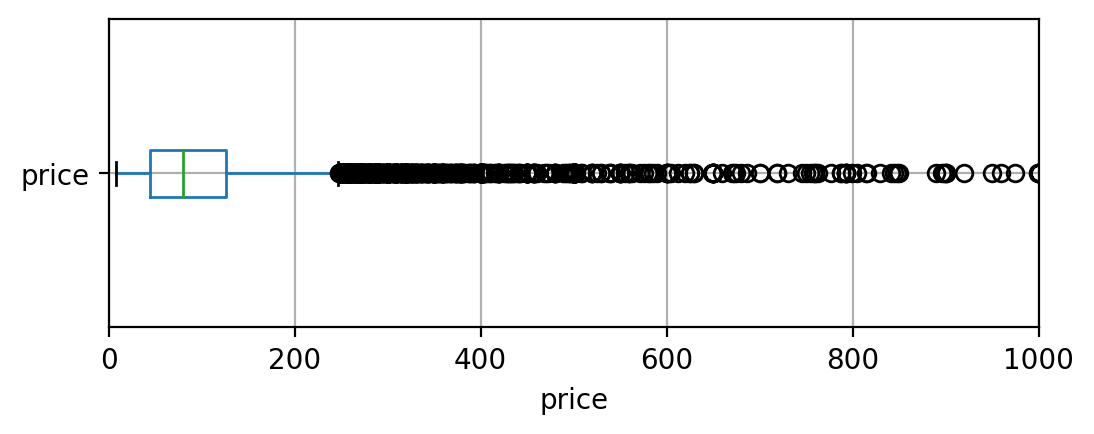

In [39]:
df.boxplot(column='price', vert=False, figsize=(6,2))
plt.xlabel('price')
plt.xlim(0, 1000)

Target has a lognormal distribution and a long tail of outliers beyond 250 EUR. We see a number of samples with price abobe 500 EUR is close to zero.

#### Conclusions

Since the target has a lognormal distribution, we take $log_{10}$ from it to predict. To restore the price from the forecast, we will raise 10 to the power of the predicted value. We excleude samples with price greater than 500 EUR from traing and test dataset.

To eliminate rare observations and outliers, we limit the feature values as follows.
- accomodates less than 11;
- bedrooms less then 6;
- beds less then 11.

If the model is to be used to make predictions with feature values outside these limits, the model will return -1 as a prediction.

### Non-numerical features

Now we take a general look at how many unique values each of the non-numerical features contain, and how often their most frequent category is represented.

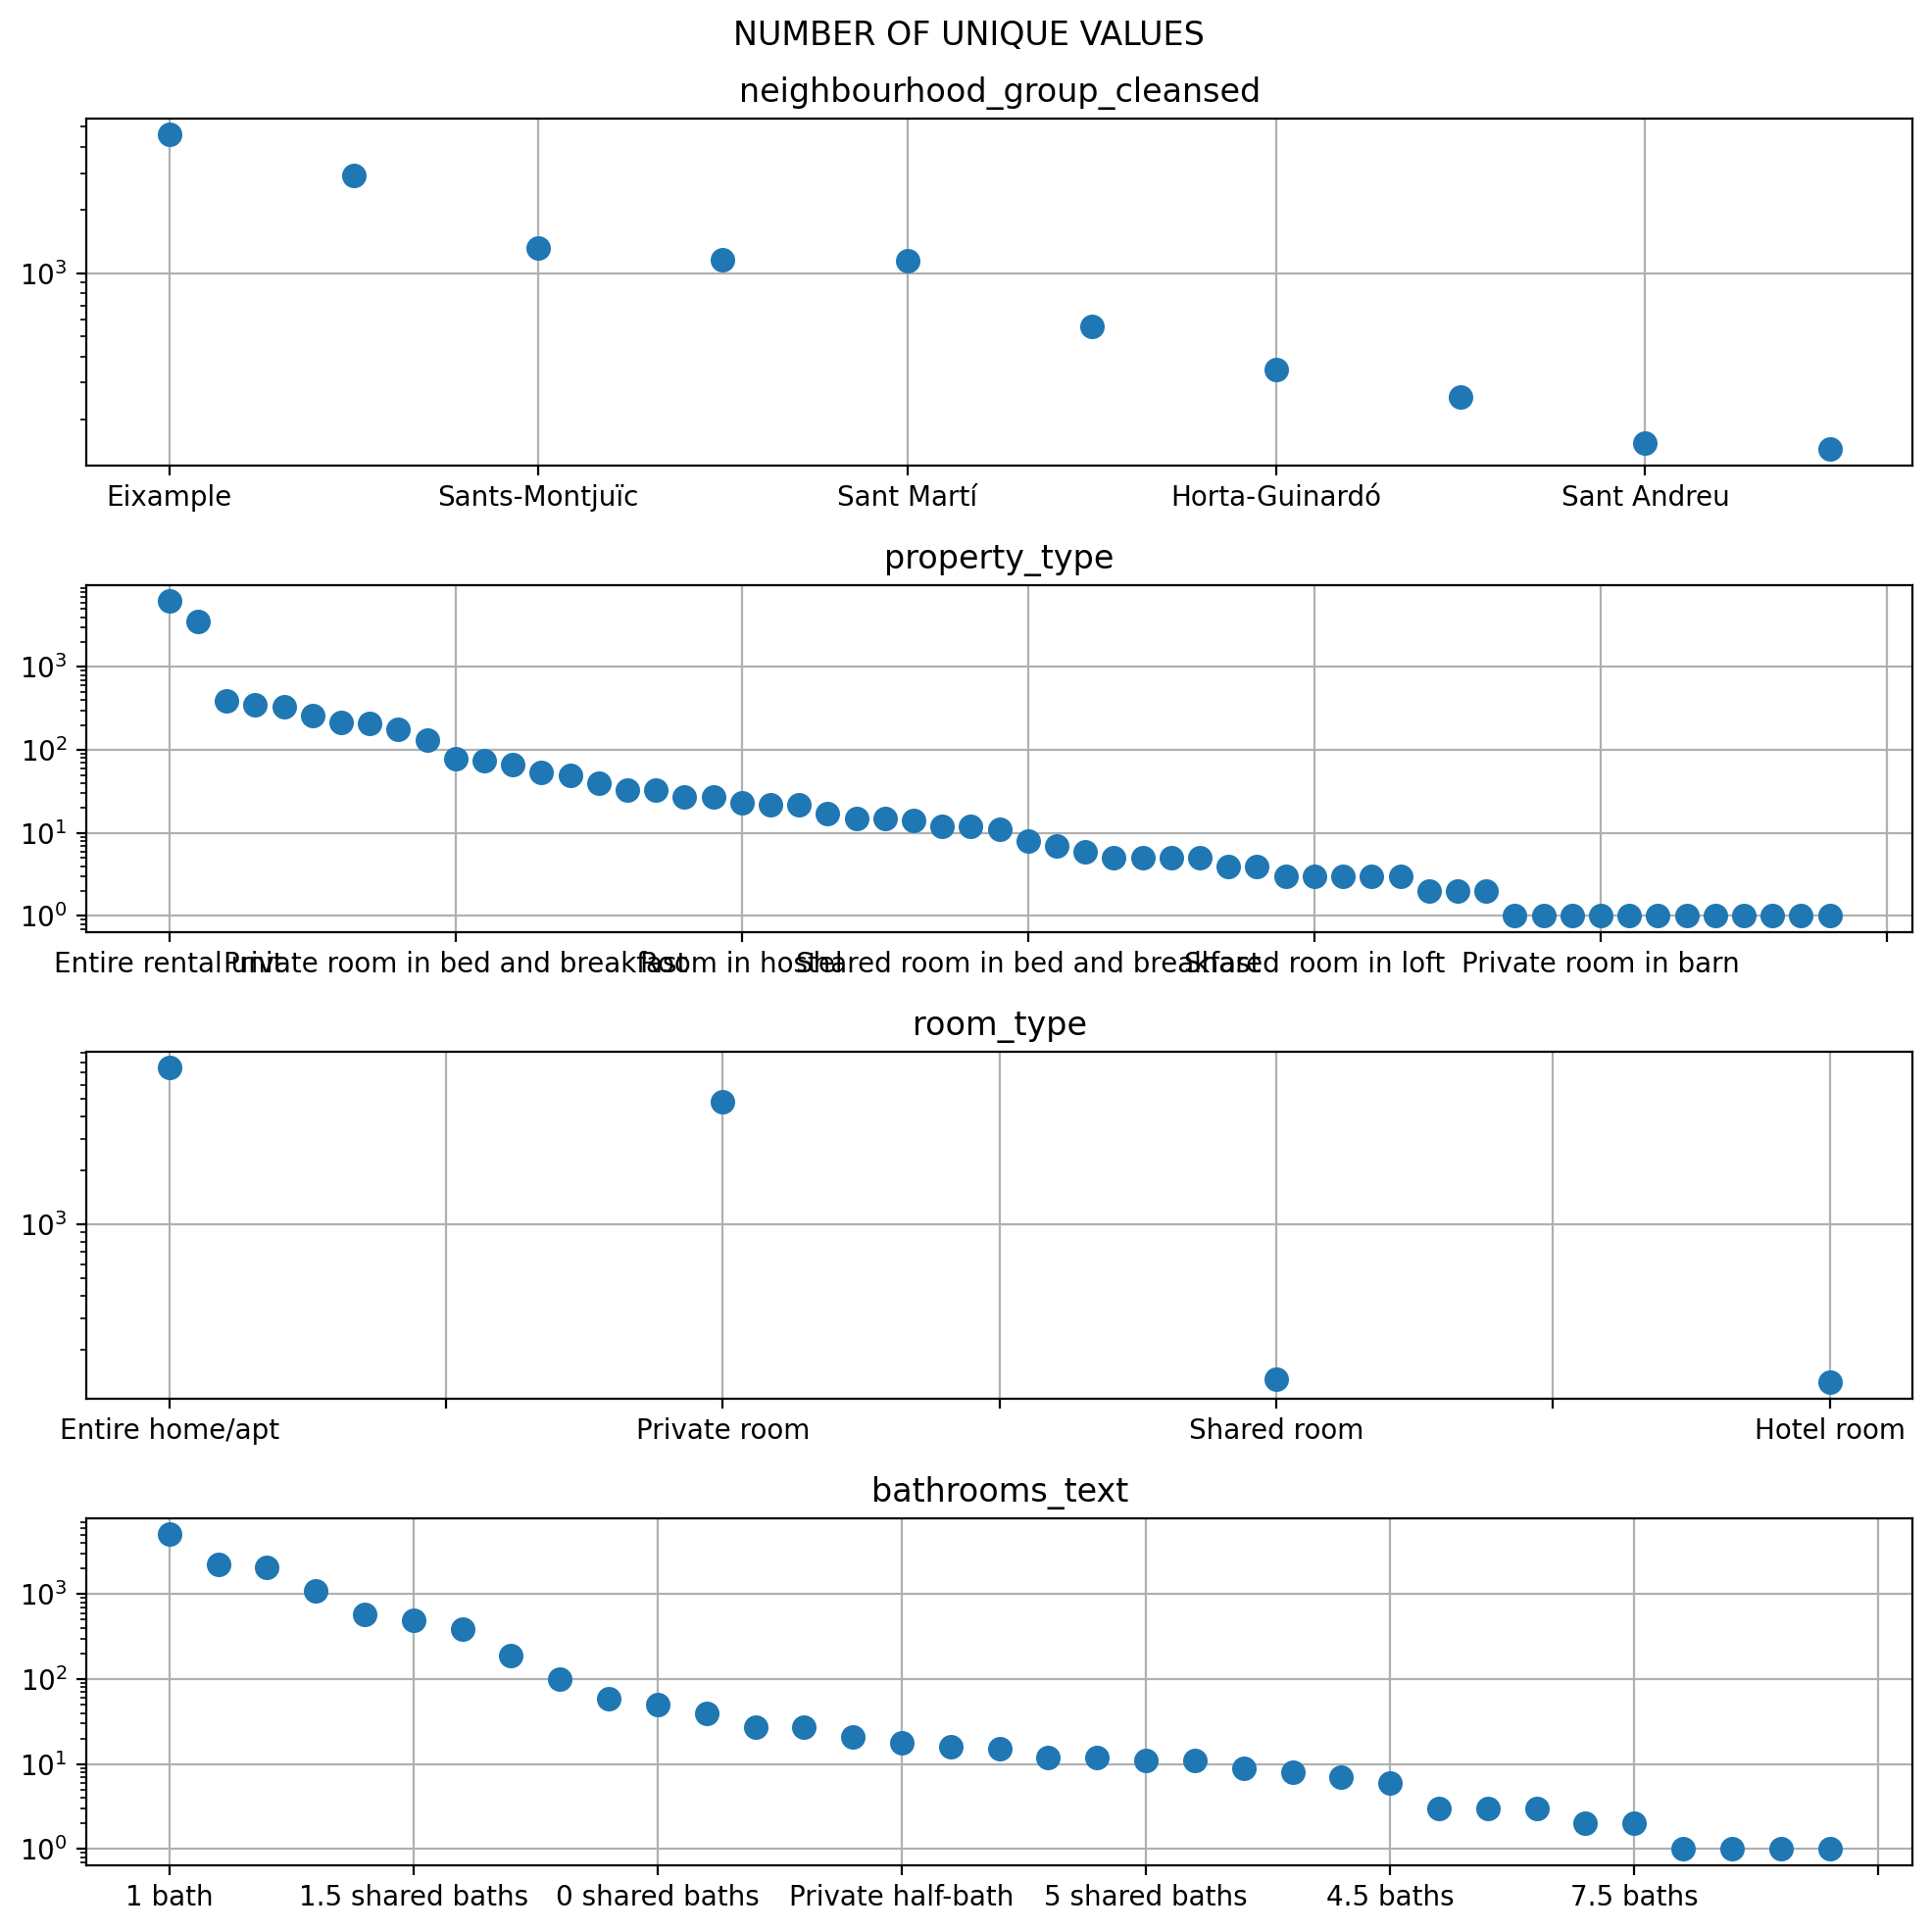

In [40]:
columns = df.select_dtypes(exclude='number').columns.to_list()

fig, axes = plt.subplots(ncols=1,
                         nrows=len(columns),
                         figsize=(10, 10))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df[col].value_counts().plot(
        logy=True,
        title=col,
        lw=0,
        marker='.',
        ax=ax,
        markersize=16,
        grid=True)

plt.suptitle("Number of unique values".upper())
plt.tight_layout()
plt.show()

We see an exponential distribution of the number of samples per categorical feature value for each feature in the dataset.

There are no critical problems for model training, although there is certainly room for subsequent optimization and feature engineering.

## Conclusions

The following conclusions were drawn from the explanatory data analysis:

- There are duplicates in the data set and they need to be removed.
- There are also missing values in the dataset. Since the number of samples with missing values is less than 10%, we simply discard them as an initial approach to handling the cleanup step.
- Data type errors have been identified that should be eliminated during data cleansing: the target `price` and the `host_is_superhost` feature must be converted to a numeric type.
- Numerical features `bedrooms`, `beds` and `accommodates` have a low cardinality. They can be treated as categorical.
- Since the target has a lognormal distribution, we take $log_{10}$ from it to predict. To restore the price from the forecast, we will raise 10 to the power of the predicted value. 
- We exclude samples with price greater than 500 EUR from the training and test dataset.
- To eliminate rare observations and outliers, we limit the feature values as follows:
    - accommodates less than 11;
    - bedrooms less than 6;
    - beds less than 11.
- If the model is to be used to make predictions with feature values outside these limits, the model will return -1 as a prediction.